In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indoor-location-navigation/sample_submission.csv
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/B1/geojson_map.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/B1/floor_info.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/B1/floor_image.png
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F3/geojson_map.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F3/floor_info.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F3/floor_image.png
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F2/geojson_map.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F2/floor_info.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F2/floor_image.png
/kaggle/input/indoor-location-navigation/metadata/5cdbc652853bc856e89a8694/B1/geojson_ma

In [2]:
import json
import re
import gc
import pickle
import itertools
import pandas as pd
import numpy as np
from glob import glob
from datetime import datetime as dt
from pathlib import Path
from tqdm import tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # ut(10 digit) -> date

# pandas settings -----------------------------------------
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.5f}'.format

# Graph drawing -------------------------------------------
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib_venn import venn2, venn2_circles
from matplotlib import animation as ani
from IPython.display import Image
from pylab import imread

plt.rcParams["patch.force_edgecolor"] = True
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

%matplotlib inline
%config InlineBackend.figure_format='retina'

# ML -------------------------------------------
from sklearn.preprocessing import LabelEncoder

In [3]:
def unpickle(filename):
    with open(filename, 'rb') as fo:
        p = pickle.load(fo)
    return p

def to_pickle(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, -1)



class FeatureStore():
    
    # necessayr to re-check
    floor_convert = {'1F' :  0, '2F' : 1, '3F' : 2, '4F' : 3, '5F' : 4, 
                     '6F' : 5, '7F' : 6, '8F' : 7, '9F' : 8,
                     'B'  : -1, 'B1' : -1, 'B2' : -2, 'B3' : -3, 
                     'BF' : -1, 'BM' : -1, 
                     'F1' : 0, 'F2' : 1, 'F3' : 2, 'F4' : 3, 'F5' : 4, 
                     'F6' : 5, 'F7' : 6, 'F8' : 7, 'F9' : 8, 'F10': 9,
                     'L1' : 0, 'L2' : 1, 'L3' : 2, 'L4' : 3, 'L5' : 4, 
                     'L6' : 5, 'L7' : 6, 'L8' : 7, 'L9' : 8, 'L10': 9, 
                     'L11': 10,
                     'G'  : 0, 'LG1': 0, 'LG2': 1, 'LM' : 0, 'M'  : 0, 
                     'P1' : 0, 'P2' : 1,}
    
    df_types = ['accelerometer',
                'accelerometer_uncalibrated',
                'beacon',
                'gyroscope',
                'gyroscope_uncalibrated',
                'magnetic_field',
                'magnetic_field_uncalibrated',
                'rotation_vector',
                'waypoint',
                'wifi']
    
    # https://github.com/location-competition/indoor-location-competition-20
    df_type_cols = {'accelerometer': ["timestamp", "x", "y", "z", "accuracy"],
                'accelerometer_uncalibrated': ["timestamp", "x", "y", "z", 
                                               "x2", "y2", "z2", "accuracy" ],
                'beacon': ["timestamp", "uuid", "major_id", "minor_id", "tx_power", 
                           "rssi", "distance", "mac_addr", "timestamp2"],
                'gyroscope': ["timestamp", "x", "y", "z", "accuracy"],
                'gyroscope_uncalibrated': ["timestamp", "x", "y", "z", 
                                           "x2", "y2", "z2", "accuracy" ],
                'magnetic_field': ["timestamp", "x", "y", "z", "accuracy"],
                'magnetic_field_uncalibrated': ["timestamp", "x", "y", "z", 
                                                "x2", "y2", "z2", "accuracy" ],
                'rotation_vector': ["timestamp", "x", "y", "z", "accuracy"],
                'waypoint': ["timestamp", "x", "y"],
                'wifi': ["timestamp", "ssid", "bssid","rssi","frequency",
                         "last_seen_timestamp",]}

    dtype_dict = {}
    dtype_dict["accelerometer"] = {"timestamp":int, "x":float, "y":float, "z":float, 
                                   "accuracy":int}
    dtype_dict["accelerometer_uncalibrated"] = {"timestamp":int, "x":float, "y":float, 
                                                "z":float, "x2":float, "y2":float, 
                                                "z2":float, "accuracy":int}
    dtype_dict["beacon"] = {"timestamp":int, "uuid":str, "major_id":str, 
                            "minor_id":str, "tx_power":int,  "rssi":int, 
                            "distance":float, "mac_addr":str, "timestamp2":int}
    dtype_dict["gyroscope"] = {"timestamp":int, "x":float, "y":float, "z":float, 
                               "accuracy":int}
    dtype_dict["gyroscope_uncalibrated"] = {"timestamp":int, "x":float, "y":float, 
                                            "z":float, "x2":float, "y2":float, 
                                            "z2":float, "accuracy":int}
    dtype_dict["magnetic_field"] = {"timestamp":int, "x":float, "y":float, 
                                    "z":float, "accuracy":int}
    dtype_dict["magnetic_field_uncalibrated"] = {"timestamp":int, "x":float, 
                                                 "y":float, "z":float, "x2":float, 
                                                 "y2":float, "z2":float, "accuracy":int}
    dtype_dict["rotation_vector"] = {"timestamp":int, "x":float, "y":float, 
                                     "z":float, "accuracy":int}
    dtype_dict["waypoint"] = {"timestamp":int, "x":float, "y":float, "z":float}
    dtype_dict["wifi"] = {"timestamp":int, "ssid":str, "bssid":str,
                          "rssi":int,"frequency":int, "last_seen_timestamp":int}

    def __init__(self, site_id, floor, path_id, 
                 input_path="../input/indoor-location-navigation/",
                 save_path="../mid"):
        self.site_id = site_id
        self.floor = floor
        self.n_floor = self.floor_convert[floor]
        
        self.path_id = path_id
        
        self.input_path = input_path
        assert Path(input_path).exists(), f"input_path do not exist: {input_path}"
        
        self.save_path = save_path
        Path(save_path).mkdir(parents=True, exist_ok=True)
        
        self.site_info = SiteInfo(site_id=self.site_id, floor=self.floor, input_path=self.input_path)
        
    def _flatten(self, l):
        return list(itertools.chain.from_iterable(l))
    
    def multi_line_spliter(self, s):
        matches = re.finditer("TYPE_", s)
        matches_positions = [match.start() for match in matches]
        split_idx = [0] + [matches_positions[i]-14 for i in range(1, len(matches_positions))] + [len(s)]
        return [s[split_idx[i]:split_idx[i+1]] for i in range(len(split_idx)-1)]
    
    def load_df(self, ):
        path = str(Path(self.input_path)/f"train/{self.site_id}/{self.floor}/{self.path_id}.txt")
        with open(path) as f:
            data = f.readlines()
        
        modified_data = []
        for s in data:
            if s.count("TYPE_")>1:
                lines = self.multi_line_spliter(s)
                modified_data.extend(lines)
            else:
                modified_data.append(s)
        del data
        self.meta_info_len = len([d for d in modified_data if d[0]=="#"])
        self.meta_info_df = pd.DataFrame([m.replace("\n", "").split(":") 
                                          for m in self._flatten([d.split("\t") 
                                                                  for d in modified_data if d[0]=="#"]) if m!="#"])

        data_df = pd.DataFrame([d.replace("\n", "").split("\t") for d in modified_data if d[0]!="#"])
        for dt in self.df_types:
            # select data type
            df_s = data_df[data_df[1]==f"TYPE_{dt.upper()}"]
            if len(df_s)==0:
                setattr(self, dt, pd.DataFrame(columns=self.df_type_cols[dt]))
            else:
                # remove empty cols
                na_info = df_s.isna().sum(axis=0) == len(df_s)
                df_s = df_s[[i for i in na_info[na_info==False].index if i!=1]].reset_index(drop=True)
                
                if len(df_s.columns)!=len(self.df_type_cols[dt]):
                    df_s.columns = self.df_type_cols[dt][:len(df_s.columns)]
                else:
                    df_s.columns = self.df_type_cols[dt]
            
                # set dtype          
                for c in df_s.columns:
                    df_s[c] = df_s[c].astype(self.dtype_dict[dt][c])
                                     
                # set DataFrame to attr
                setattr(self, dt, df_s)
    
    def get_site_info(self, keep_raw=False):
        self.site_info.get_site_info(keep_raw=keep_raw)
            
    def load_all_data(self, keep_raw=False):     
        self.load_df()
        self.get_site_info(keep_raw=keep_raw)
        
    def __getitem__(self, item):
        if item in self.df_types:
            return getattr(self, item)
        else:
            return None
    
    def save(self, ):
        # to be implemented
        pass
    
    
class SiteInfo():
    def __init__(self, site_id, floor, input_path="../input/indoor-location-navigation/"):
        self.site_id = site_id
        self.floor = floor
        self.input_path = input_path
        assert Path(input_path).exists(), f"input_path do not exist: {input_path}"
        
    def get_site_info(self, keep_raw=False):
        floor_info_path = f"{self.input_path}/metadata/{self.site_id}/{self.floor}/floor_info.json"
        with open(floor_info_path, "r") as f:
            self.floor_info = json.loads(f.read())
            self.site_height = self.floor_info["map_info"]["height"]
            self.site_width = self.floor_info["map_info"]["width"]
            if not keep_raw:
                del self.floor_info
            
        geojson_map_path = f"{self.input_path}/metadata/{self.site_id}/{self.floor}/geojson_map.json"
        with open(geojson_map_path, "r") as f:
            self.geojson_map = json.loads(f.read())
            self.map_type = self.geojson_map["type"]
            self.features = self.geojson_map["features"]
            
            self.floor_coordinates = self.features[0]["geometry"]["coordinates"]
            self.store_coordinates = [self.features[i]["geometry"]["coordinates"] 
                                          for i in range(1, len(self.features))]
                
            if not keep_raw:
                del self.geojson_map
    
    def show_site_image(self):
        path = f"{self.input_path}/metadata/{self.site_id}/{self.floor}/floor_image.png"
        plt.imshow(imread(path), extent=[0, self.site_width, 0, self.site_height])

    def draw_polygon(self, size=8, only_floor=False):

        fig = plt.figure()
        ax = plt.subplot(111)
            
        xmax, xmin, ymax, ymin = self._draw(self.floor_coordinates, ax, calc_minmax=True)
        if not only_floor:
            self._draw(self.store_coordinates, ax, fill=True)
        plt.legend([])
        
        xrange = xmax - xmin
        yrange = ymax - ymin
        ratio = yrange / xrange
        
        self.x_size = size
        self.y_size = size*ratio

        fig.set_figwidth(size)
        fig.set_figheight(size*ratio)
        # plt.show()
        return ax
        
    def _draw(self, coordinates, ax, fill=False, calc_minmax=False):
        xmax, ymax = -np.inf, -np.inf
        xmin, ymin = np.inf, np.inf
        for i in range(len(coordinates)):
            ndim = np.ndim(coordinates[i])
            if ndim==2:
                corrd_df = pd.DataFrame(coordinates[i])
                if fill:
                    ax.fill(corrd_df[0], corrd_df[1], alpha=0.7)
                else:
                    corrd_df.plot.line(x=0, y=1, style="-", ax=ax)
                        
                if calc_minmax:
                    xmax = max(xmax, corrd_df[0].max())
                    xmin = min(xmin, corrd_df[0].min())

                    ymax = max(ymax, corrd_df[1].max())
                    ymin = min(ymin, corrd_df[1].min())
            elif ndim==3:
                for j in range(len(coordinates[i])):
                    corrd_df = pd.DataFrame(coordinates[i][j])
                    if fill:
                        ax.fill(corrd_df[0], corrd_df[1], alpha=0.6)
                    else:
                        corrd_df.plot.line(x=0, y=1, style="-", ax=ax)
                        
                    if calc_minmax:
                        xmax = max(xmax, corrd_df[0].max())
                        xmin = min(xmin, corrd_df[0].min())

                        ymax = max(ymax, corrd_df[1].max())
                        ymin = min(ymin, corrd_df[1].min())
            else:
                assert False, f"ndim of coordinates should be 2 or 3: {ndim}"
        if calc_minmax:
            return xmax, xmin, ymax, ymin
        else:
            return None

In [4]:
# site_meta_data
site_meta_data = pd.DataFrame([[p.split("/")[-2], p.split("/")[-1]] for p in glob("../input/indoor-location-navigation/metadata/**/*")])
site_meta_data.columns = ["site_id", "floor"]
site_meta_data.head()

site_id floor
0  5cd56c0ce2acfd2d33b6ab27    B1
1  5cd56c0ce2acfd2d33b6ab27    F3
2  5cd56c0ce2acfd2d33b6ab27    F2
3  5cdbc652853bc856e89a8694    B1
4  5cdbc652853bc856e89a8694    F1

In [5]:
# train_meta_data
train_meta = glob("../input/indoor-location-navigation/train/*/*/*")
train_meta_org = pd.DataFrame(train_meta)
train_meta = train_meta_org[0].str.split("/", expand=True)[[4, 5, 6]]
train_meta.columns = ["site_id", "floor", "path_id"]
train_meta["path_id"] = train_meta["path_id"].str.replace(".txt", "")
train_meta["path"] = train_meta_org[0]
train_meta.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


site_id floor                   path_id  \
0  5cd56c0ce2acfd2d33b6ab27    B1  5d09a625bd54340008acddb9   
1  5cd56c0ce2acfd2d33b6ab27    B1  5d09a625bd54340008acddb7   
2  5cd56c0ce2acfd2d33b6ab27    B1  5d09a625249b920008be0cba   
3  5cd56c0ce2acfd2d33b6ab27    B1  5d09a625249b920008be0cbc   
4  5cd56c0ce2acfd2d33b6ab27    F3  5d09b23fcfb49b00085466aa   

                                                                                                 path  
0  ../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/B1/5d09a625bd54340008acddb9.txt  
1  ../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/B1/5d09a625bd54340008acddb7.txt  
2  ../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/B1/5d09a625249b920008be0cba.txt  
3  ../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/B1/5d09a625249b920008be0cbc.txt  
4  ../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/F3/5d09b23fcfb49b00085466aa.txt

# Train Data

In [6]:
t = train_meta.iloc[512]
print(f"site_id: {t.site_id}, floor: {t.floor}, path_id: {t.path_id}")
feature = FeatureStore(site_id=t.site_id, floor=t.floor, path_id=t.path_id)
feature.load_all_data()

site_id: 5da138764db8ce0c98bcaa46, floor: F1, path_id: 5daae258df065a00069becc7


In [7]:
# attributes of feature store
[c for c in dir(feature) if c[0]!="_"]

['accelerometer',
 'accelerometer_uncalibrated',
 'beacon',
 'df_type_cols',
 'df_types',
 'dtype_dict',
 'floor',
 'floor_convert',
 'get_site_info',
 'gyroscope',
 'gyroscope_uncalibrated',
 'input_path',
 'load_all_data',
 'load_df',
 'magnetic_field',
 'magnetic_field_uncalibrated',
 'meta_info_df',
 'meta_info_len',
 'multi_line_spliter',
 'n_floor',
 'path_id',
 'rotation_vector',
 'save',
 'save_path',
 'site_id',
 'site_info',
 'waypoint',
 'wifi']

In [8]:
# attributes of site info
[c for c in dir(feature.site_info) if c[0]!="_"]

['draw_polygon',
 'features',
 'floor',
 'floor_coordinates',
 'get_site_info',
 'input_path',
 'map_type',
 'show_site_image',
 'site_height',
 'site_id',
 'site_width',
 'store_coordinates']

In [9]:
feature.site_info.site_height, feature.site_info.site_width

(212.0599746644009, 146.74902374734265)

In [10]:
for d in feature.df_types:
    print(d)
    print(feature[d].info())
    display(feature[d].head())

accelerometer
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  768 non-null    int64  
 1   x          768 non-null    float64
 2   y          768 non-null    float64
 3   z          768 non-null    float64
 4   accuracy   768 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 30.1 KB
None


timestamp        x       y       z  accuracy
0  1571479971068 -0.21936 0.84453 9.54700         2
1  1571479971088 -0.17986 0.72122 9.28363         2
2  1571479971108  0.02844 0.51114 9.13280         2
3  1571479971128 -0.11760 0.56262 8.85925         2
4  1571479971148 -0.16550 0.62845 8.62224         2

accelerometer_uncalibrated
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  768 non-null    int64  
 1   x          768 non-null    float64
 2   y          768 non-null    float64
 3   z          768 non-null    float64
 4   x2         768 non-null    float64
 5   y2         768 non-null    float64
 6   z2         768 non-null    float64
 7   accuracy   768 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 48.1 KB
None


timestamp        x       y       z      x2      y2      z2  accuracy
0  1571479971068 -0.18285 0.76372 9.31715 0.00000 0.00000 0.00000         3
1  1571479971088 -0.24271 0.82597 9.50510 0.00000 0.00000 0.00000         3
2  1571479971108 -0.05417 0.60690 9.18008 0.00000 0.00000 0.00000         3
3  1571479971128 -0.02124 0.50575 9.00650 0.00000 0.00000 0.00000         3
4  1571479971148 -0.17328 0.62906 8.74254 0.00000 0.00000 0.00000         3

beacon
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   8 non-null      int64  
 1   uuid        8 non-null      object 
 2   major_id    8 non-null      object 
 3   minor_id    8 non-null      object 
 4   tx_power    8 non-null      int64  
 5   rssi        8 non-null      int64  
 6   distance    8 non-null      float64
 7   mac_addr    8 non-null      object 
 8   timestamp2  8 non-null      int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 704.0+ bytes
None


timestamp                                      uuid  \
0  1571479975350  726388c292214e8a10ee4ae58707e9972ef10261   
1  1571479977556  726388c292214e8a10ee4ae58707e9972ef10261   
2  1571479978900  726388c292214e8a10ee4ae58707e9972ef10261   
3  1571479980433  726388c292214e8a10ee4ae58707e9972ef10261   
4  1571479980742  726388c292214e8a10ee4ae58707e9972ef10261   

                                   major_id  \
0  b6589fc6ab0dc82cf12099d1c2d40ab994e8410c   
1  b6589fc6ab0dc82cf12099d1c2d40ab994e8410c   
2  b6589fc6ab0dc82cf12099d1c2d40ab994e8410c   
3  b6589fc6ab0dc82cf12099d1c2d40ab994e8410c   
4  b6589fc6ab0dc82cf12099d1c2d40ab994e8410c   

                                   minor_id  tx_power  rssi  distance  \
0  72e9b0837c5a2c2535da9b0e8fe4a0c389b04f51       -59   -99  48.76210   
1  72e9b0837c5a2c2535da9b0e8fe4a0c389b04f51       -59   -97  41.67906   
2  a5545296721299579e56c41888bd3b60e9287b43       -59   -94  32.73764   
3  a5545296721299579e56c41888bd3b60e9287b43       -59   -90  23.44428   
4  a5545296721299579e56c41888bd3b60e9287b43       -59   -94  32.73764   

                                   mac_addr     timestamp2  
0  74f8d46a4189f6192f09d54203a264ae848e54f8  1571479975350  
1  74f8d46a4189f6192f09d54203a264ae848e54f8  1571479977556  
2  cd2ad33f26c88ae518e8b6b084620fae926634c3  1571479978900  
3  cd2ad33f26c88ae518e8b6b084620fae926634c3  1571479980433  
4  cd2ad33f26c88ae518e8b6b084620fae926634c3  1571479980742

gyroscope
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  768 non-null    int64  
 1   x          768 non-null    float64
 2   y          768 non-null    float64
 3   z          768 non-null    float64
 4   accuracy   768 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 30.1 KB
None


timestamp        x        y       z  accuracy
0  1571479971068 -0.19238  0.03113 0.09709         3
1  1571479971088 -0.16096  0.05190 0.09869         3
2  1571479971108 -0.10770  0.09131 0.08379         3
3  1571479971128 -0.15511  0.02420 0.03796         3
4  1571479971148 -0.22647 -0.01895 0.02785         3

gyroscope_uncalibrated
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  768 non-null    int64  
 1   x          768 non-null    float64
 2   y          768 non-null    float64
 3   z          768 non-null    float64
 4   x2         768 non-null    float64
 5   y2         768 non-null    float64
 6   z2         768 non-null    float64
 7   accuracy   768 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 48.1 KB
None


timestamp        x        y       z      x2       y2      z2  accuracy
0  1571479971068 -0.19217  0.02892 0.09731 0.00021 -0.00221 0.00021         3
1  1571479971088 -0.16075  0.04968 0.09891 0.00021 -0.00221 0.00021         3
2  1571479971108 -0.10748  0.08910 0.08400 0.00021 -0.00221 0.00021         3
3  1571479971128 -0.15489  0.02199 0.03818 0.00021 -0.00221 0.00021         3
4  1571479971148 -0.22626 -0.02116 0.02806 0.00021 -0.00221 0.00021         3

magnetic_field
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  768 non-null    int64  
 1   x          768 non-null    float64
 2   y          768 non-null    float64
 3   z          768 non-null    float64
 4   accuracy   768 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 30.1 KB
None


timestamp        x        y         z  accuracy
0  1571479971068 -4.51508 32.10907 -25.91400         3
1  1571479971088 -4.51508 33.49609 -28.59497         3
2  1571479971108 -1.04675 32.80335 -25.91400         3
3  1571479971128 -5.20935 32.80335 -26.58539         3
4  1571479971148 -3.12805 31.41632 -25.24414         3

magnetic_field_uncalibrated
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  768 non-null    int64  
 1   x          768 non-null    float64
 2   y          768 non-null    float64
 3   z          768 non-null    float64
 4   x2         768 non-null    float64
 5   y2         768 non-null    float64
 6   z2         768 non-null    float64
 7   accuracy   768 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 48.1 KB
None


timestamp         x         y          z        x2        y2  \
0  1571479971068 -37.46185 -54.80652 -360.62775 -32.94678 -86.91559   
1  1571479971088 -37.46185 -53.41949 -363.30872 -32.94678 -86.91559   
2  1571479971108 -33.99353 -54.11224 -360.62775 -32.94678 -86.91559   
3  1571479971128 -38.15613 -54.11224 -361.29913 -32.94678 -86.91559   
4  1571479971148 -36.07483 -55.49927 -359.95790 -32.94678 -86.91559   

          z2  accuracy  
0 -334.71375         3  
1 -334.71375         3  
2 -334.71375         3  
3 -334.71375         3  
4 -334.71375         3

rotation_vector
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  768 non-null    int64  
 1   x          768 non-null    float64
 2   y          768 non-null    float64
 3   z          768 non-null    float64
 4   accuracy   768 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 30.1 KB
None


timestamp       x       y        z  accuracy
0  1571479971068 0.03570 0.00550 -0.04846         3
1  1571479971088 0.03688 0.00689 -0.04835         3
2  1571479971108 0.03653 0.00783 -0.04697         3
3  1571479971128 0.03381 0.00633 -0.04591         3
4  1571479971148 0.03162 0.00608 -0.04564         3

waypoint
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3 non-null      int64  
 1   x          3 non-null      float64
 2   y          3 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 200.0 bytes
None


timestamp        x        y
0  1571479970950 84.74026 30.95397
1  1571479976338 84.31673 38.00580
2  1571479985254 76.35599 37.89630

wifi
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   timestamp            466 non-null    int64 
 1   ssid                 466 non-null    object
 2   bssid                466 non-null    object
 3   rssi                 466 non-null    int64 
 4   frequency            466 non-null    int64 
 5   last_seen_timestamp  466 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 22.0+ KB
None


timestamp                                      ssid  \
0  1571479972829  e07bf45ca5943d83811a25cbc7e017ad6e6886d7   
1  1571479972829  58dc84a0563dfc2784380138449d2ae7e649b49e   
2  1571479972829  e07bf45ca5943d83811a25cbc7e017ad6e6886d7   
3  1571479972829  fe86a97300ba8f04244db1c0a0e466b5d7826ff3   
4  1571479972829  64f1125cb0e5e507a7ba5c32dd76bd506f30ce94   

                                      bssid  rssi  frequency  \
0  e4eae6922421f35b8d647b3a326c3afb7470648c   -57       5240   
1  475e5087986b19f5b4866493e7d1227189bda03c   -64       2412   
2  944d4753e787b02a3cffd49086d3b1b820fe3101   -66       2412   
3  a03f0fd240970f7fee68a9033451a19d91a0182a   -70       2462   
4  d7b95971d9bfaca7a11fe8d4ce089ff4c73a3fcc   -72       5805   

   last_seen_timestamp  
0        1571479972019  
1        1571479951401  
2        1571479971016  
3        1571479946311  
4        1571479946928

In [11]:
feature.meta_info_df.head()

0                         1
0  startTime             1571479970943
1     SiteID  5da138764db8ce0c98bcaa46
2   SiteName                      银泰百货
3    FloorId  5da1387a4db8ce0c98bcad26
4  FloorName                        F1

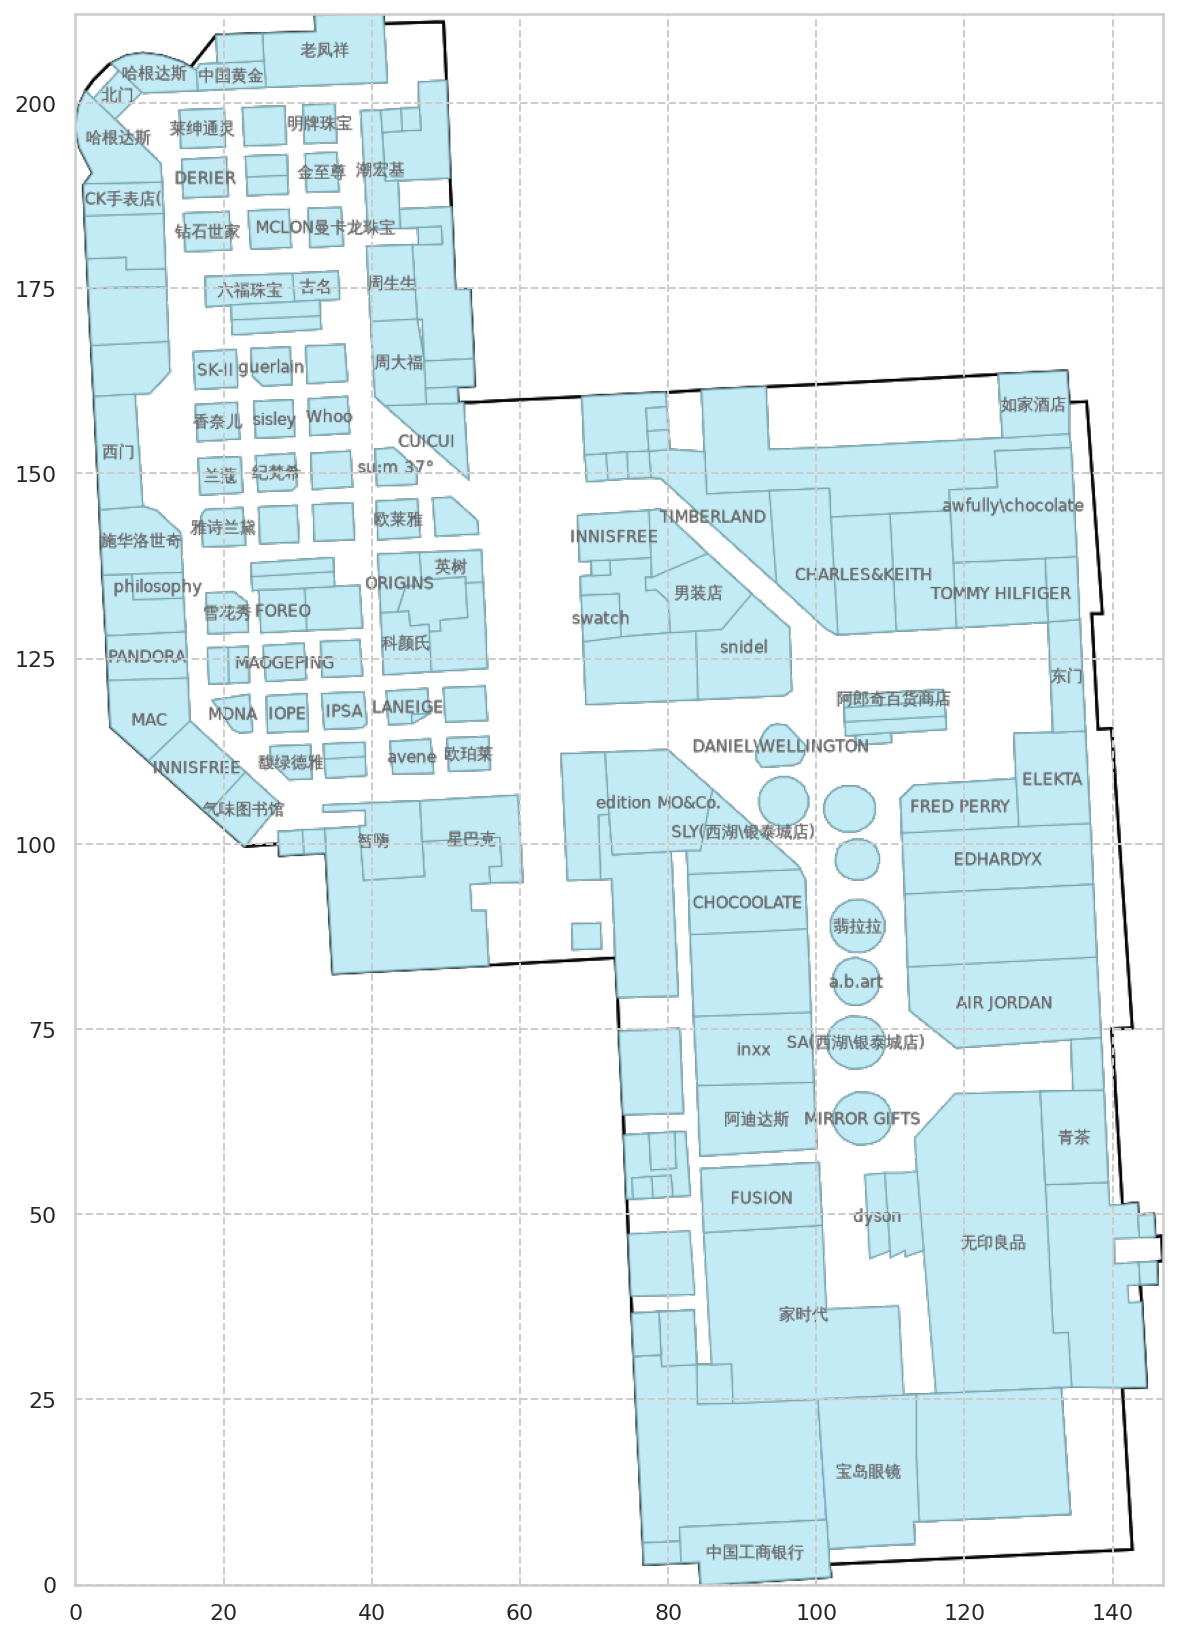

In [12]:
plt.figure(figsize=(10, 10*feature.site_info.site_height / feature.site_info.site_width))
feature.site_info.show_site_image()

<AxesSubplot:xlabel='0'>

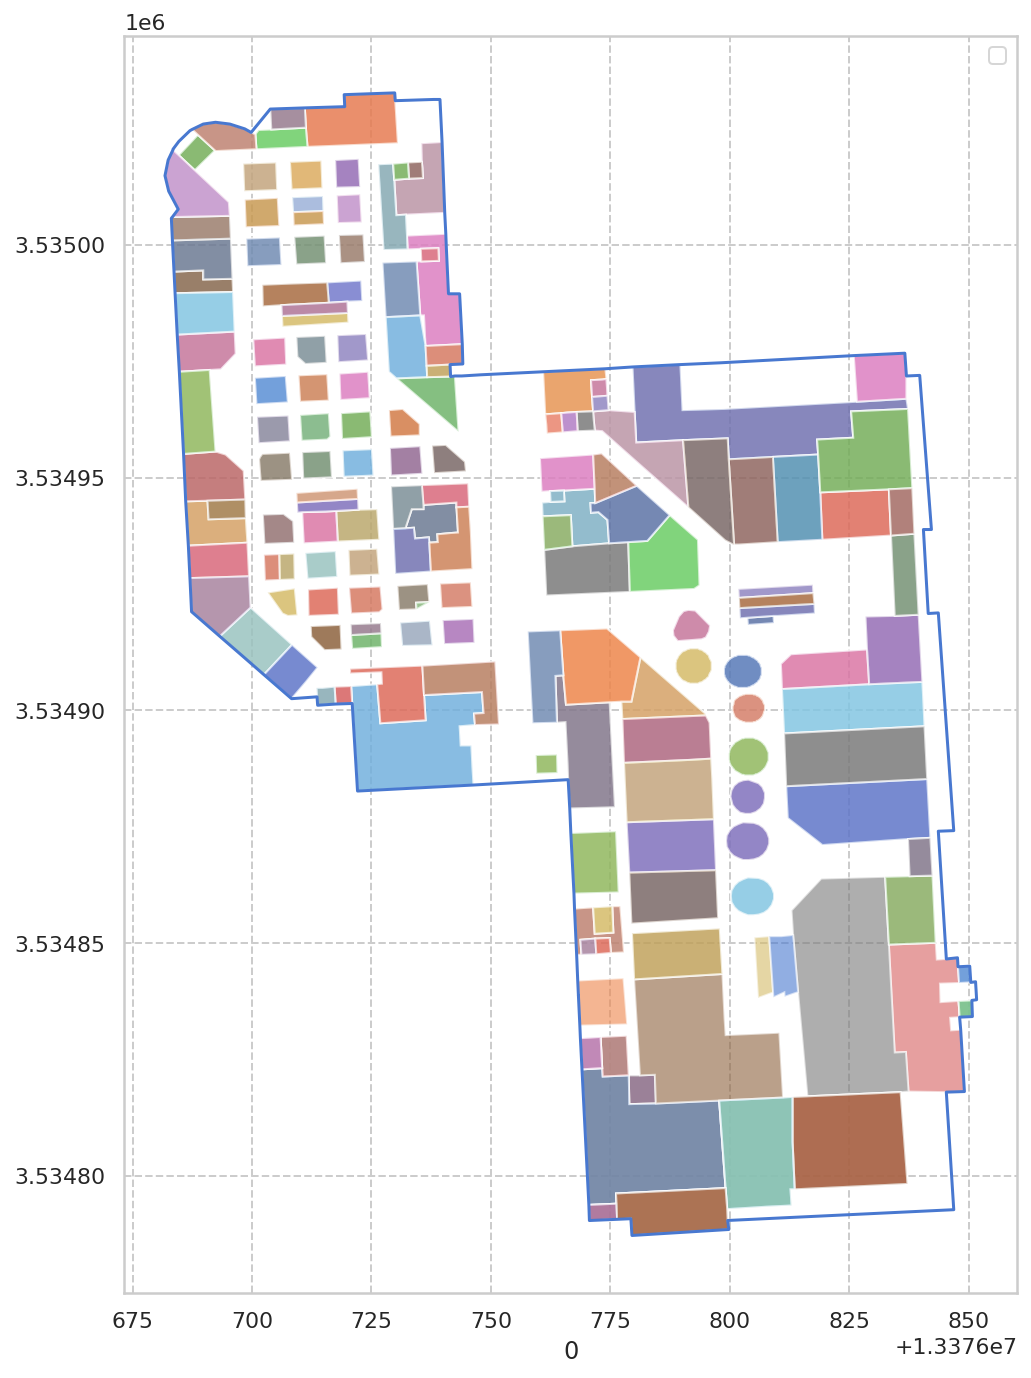

In [13]:
feature.site_info.draw_polygon()

In [14]:
feature.site_info.floor_coordinates[0][:10]

[[13376768.312767826, 3534838.769755661],
 [13376768.61746229, 3534832.253334415],
 [13376768.729455471, 3534829.5521690906],
 [13376769.0642129, 3534822.855338763],
 [13376770.504982464, 3534793.728414778],
 [13376770.617550643, 3534790.3741545505],
 [13376776.408518534, 3534790.6315379757],
 [13376779.299035043, 3534790.765083897],
 [13376779.521467963, 3534787.16126038],
 [13376799.785074517, 3534788.446377484]]

In [15]:
feature.site_info.store_coordinates[0]

[[[13376797.116243433, 3534865.633950164],
  [13376778.965209799, 3534865.113423728],
  [13376779.413295655, 3534854.168055645],
  [13376797.553824583, 3534855.321374025],
  [13376797.116243433, 3534865.633950164]]]

# Plot waypoint for a site.

In [16]:
# targe site
site_id = "5da138764db8ce0c98bcaa46"
floor = "F1"

# get all waypoint
waypoint_list = []
train_meta_s = train_meta.query(f"site_id=='{site_id}' and floor == '{floor}'")
for i, r in tqdm(train_meta_s.iterrows(), total=len(train_meta_s)):
    if "feature" in globals():
        del feature
        gc.collect()
    feature = FeatureStore(site_id=r.site_id, floor=r.floor, path_id=r.path_id)
    feature.load_all_data()
    feature.waypoint["path_id"] = r.path_id
    waypoint_list.append(feature.waypoint.copy())

waypoint_all = pd.concat(waypoint_list)

100%|██████████| 111/111 [00:34<00:00,  3.25it/s]


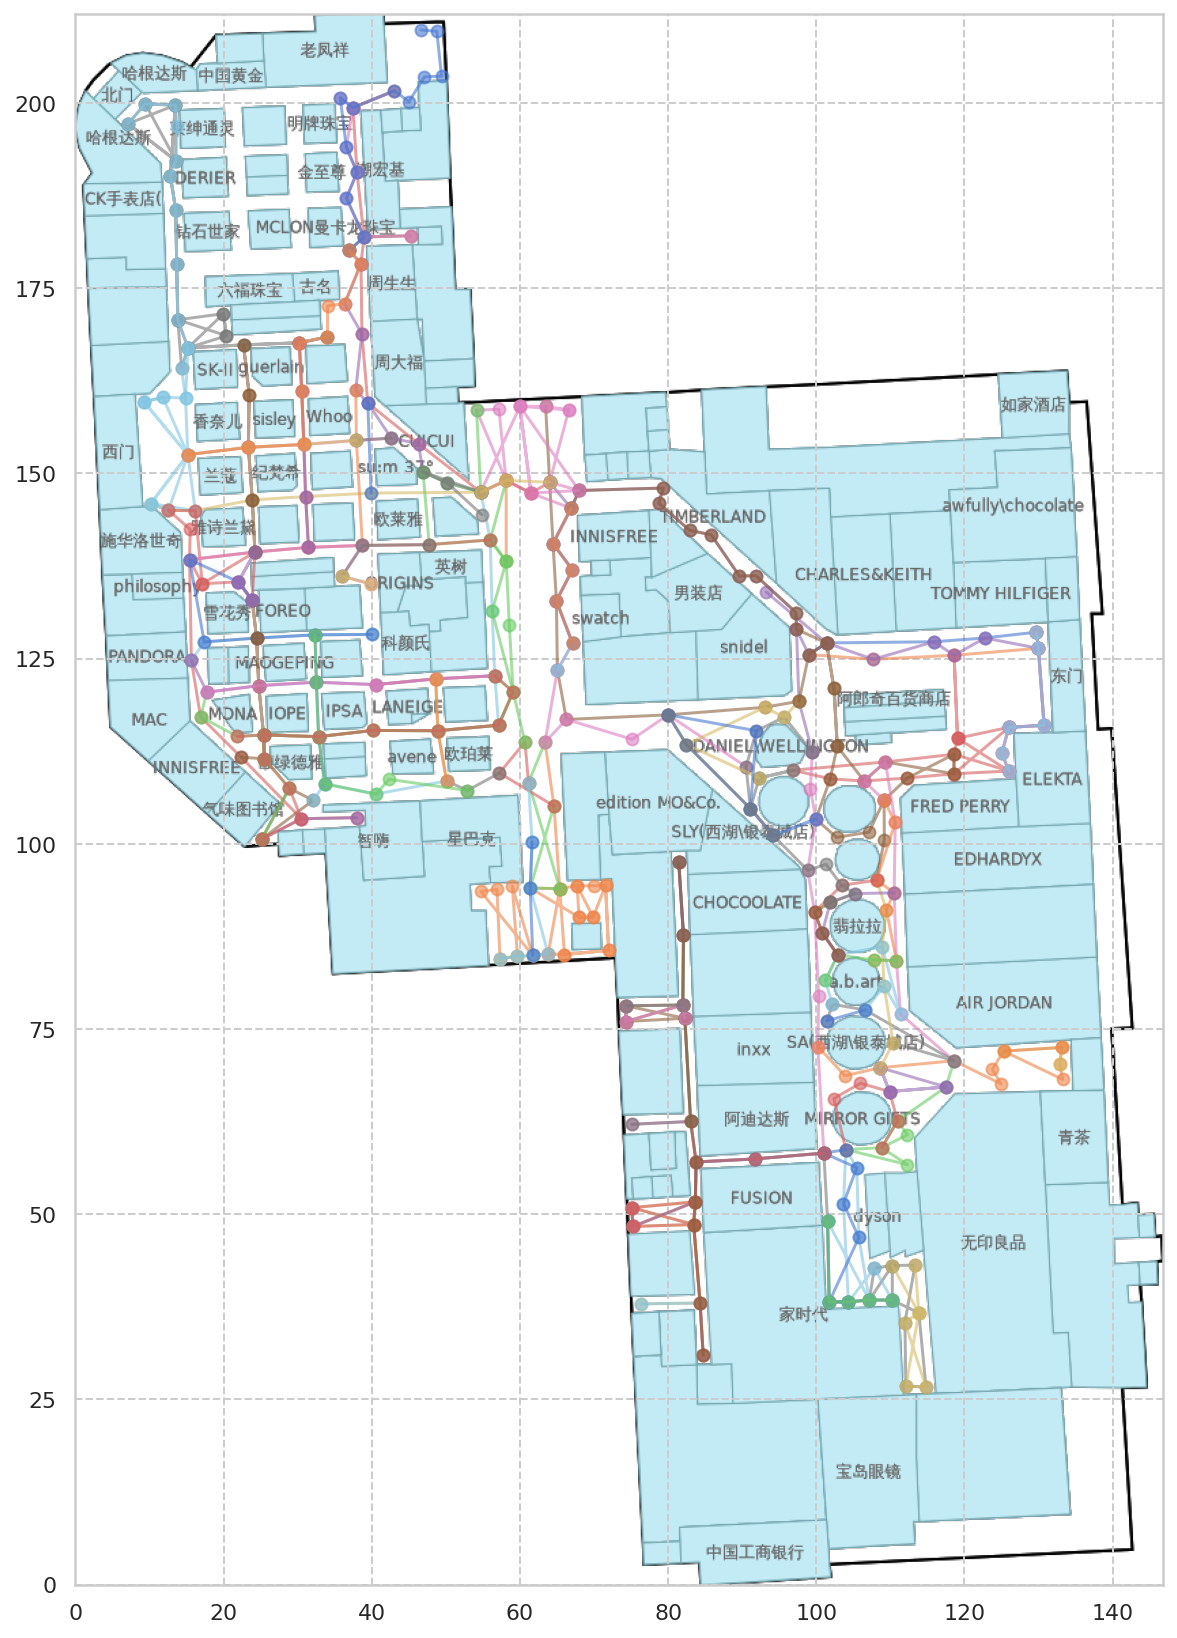

In [17]:
plt.figure(figsize=(10, 10*feature.site_info.site_height / feature.site_info.site_width))
feature.site_info.show_site_image()

for i, g in waypoint_all.groupby("path_id"):
    plt.plot(g.x, g.y, "-o", alpha=0.6,  zorder=100, )

plt.show()